In [74]:
import pandas as pd 
import re
import json
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem.lancaster import LancasterStemmer
import nltk
import gensim
from gensim import corpora, models
import math
from gensim.test.utils import datapath
import json
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
p_stemmer = PorterStemmer()
l_stemmer = LancasterStemmer()

""" 
REMINDER: TODO: Change this folder to your own folder containing the saved states
You might need to increase the ram usage for your IDE to more than 4GB
Download saved_state files here https://drive.google.com/file/d/1LdL85edkbR-YW2ZhTDnbRiblUgOnrXOU/view?usp=sharing
You require a SMU account
"""
SAVED_STATES_FOLDER = "/Users/shrmnl/Github/text-mining-g1-7/saved_states/"

## Helper functions

In [75]:
def getMajorTopic(arr):
    topic_name_id = {
        0: "Medical",
        1: "Airlines",
        2: "Schools",
        3: "Farming",
        4: "Medical",
        5: "Hollywood",
        6: "Finance",
        7: "India",
        8: "Businesses",
        9: "Football",
        10: "Europe",
        11: "US Politics",
        12: "Finance",
        13: "Automotive",
    }
    max_percentage = 0
    topic = -1
    for tup in arr:
        if tup[1] > max_percentage:
            max_percentage = tup[1]
            topic = tup[0]
    major_topic_word = topic_name_id[topic]
    return topic, max_percentage, major_topic_word

def percentageMapper(arr):
    topic_name_id = {
        0: "Medical",
        1: "Airlines",
        2: "Schools",
        3: "Farming",
        4: "Medical",
        5: "Hollywood",
        6: "Finance",
        7: "India",
        8: "Businesses",
        9: "Football",
        10: "Europe",
        11: "US Politics",
        12: "Finance",
        13: "Automotive",
    }
    result = {}
    for tup in arr:
        name = topic_name_id[tup[0]]
        if result.get(name, False) == False:
            result[name] = 0
        result[name] += tup[1]
    return result

## Lancaster stemmer very harsh not advisable
def clean_content_FASTEST(row):
    content = re.sub("\<(.*?)\>", " ", row['content'])
    content = re.sub("[^0-9a-zA-Z\&]+", " ", content).split(" ")
    processed = [l_stemmer.stem(lemmatizer.lemmatize(x.lower(), pos='v')) for x in content if x not in stopwords and x.strip() != ""]
    return processed


## Best and most trusted
def clean_content_FAST(row):
    content = re.sub("\<(.*?)\>", " ", row['content'])
    content = re.sub("[^0-9a-zA-Z\&]+", " ", content).split(" ")
    processed = [stemmer.stem(lemmatizer.lemmatize(x.lower(), pos='v')) for x in content if x not in stopwords and x.strip() != ""]
    return processed


## slower but more gentle 
def clean_content_SLOW(row):
    ## remove html tags
    content = re.sub("\<(.*?)\>", " ", row['content'])
    ## remove non alphanumeric characters
    content = re.sub("[^0-9a-zA-Z\&]+", " ", content).split(" ")
    processed = [p_stemmer.stem(x.lower()) for x in content if x not in stopwords and x.strip() != ""]
    return processed

In [ ]:
try:
    ## load the process dataframe with lda topics added already
    df = pd.read_json(f"{SAVED_STATES_FOLDER}df_processed_lda.json", orient="records")

    ## load dictionary, corpus, and lda model
    dictionary = corpora.Dictionary.load(f"{SAVED_STATES_FOLDER}dictionary")
    corpus_tfidf = corpora.MmCorpus(f"{SAVED_STATES_FOLDER}corpus")
    model_filepath = datapath(f"{SAVED_STATES_FOLDER}lda_model")
    lda_model = models.LdaModel.load(model_filepath)

except:
    pass
    ## Read the data
    df = pd.read_csv("covid19_articles_20200914.csv")

    ## Process the data
    df["processed"] = df.apply(lambda row: clean_content_FAST(row), axis=1)

    ## create dictionary, corpora, and model
    dictionary = corpora.Dictionary(df["processed"])
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in df["processed"]]
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    lda_model = models.LdaMulticore(corpus_tfidf, num_topics=14, id2word=dictionary, passes=2, workers=6, random_state=69)

    ## Save corpora, dictionary and model
    model_filepath = datapath(f"{SAVED_STATES_FOLDER}lda_model")
    lda_model.save(model_filepath)
    dictionary.save(f"{SAVED_STATES_FOLDER}dictionary")
    corpora.MmCorpus.serialize(f"{SAVED_STATES_FOLDER}corpus", corpus_tfidf) 

    ## add lda topics as a new column
    for i, row in df.iterrows():
        _, __, df.loc[i, "lda_topic"] = getMajorTopic(lda_model[corpus_tfidf[i]])

    ## save the dataframe
    result = df.to_json(orient="records")
    json.dump(result, open(f"{SAVED_STATES_FOLDER}df.json", "w+"), indent=2)

In [225]:
# Get distribution of topics and articles
topic_distribution = {}
for i in range(len(corpus_tfidf)):
    val = lda_model[corpus_tfidf[i]]
    topic, max_percentage, topic_name = getMajorTopic(val)
    if topic_distribution.get(topic_name, False) == False:
        topic_distribution[topic_name] = 0
    topic_distribution[topic_name] += 1

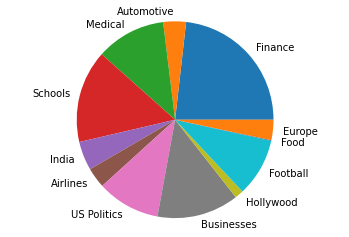

In [226]:
import matplotlib.pyplot as plt

# Data to plot
labels = topic_distribution.keys()
sizes = topic_distribution.values()

# Plot
plt.pie(sizes,labels=labels)

plt.axis('equal')
plt.show()

In [219]:
## Shishiong: This is bad
# temp = {}
# for index, row in df.iterrows():
#     domain = row["domain"]
#     content = row["processed"]
#     if temp.get(domain, False) == False:
#         temp[domain] = []
#     temp[domain] += content 
# domain_dict = {
#     "domain_name": [],
#     "processed": []
# }
# for k, v in temp.items():
#     domain_dict["domain_name"].append(k)
#     domain_dict["processed"].append(v)
# domain_df = pd.DataFrame.from_dict(domain_dict)
# domain_dictionary = corpora.Dictionary(domain_df["processed"])
# domain_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# domain_bow_corpus = [domain_dictionary.doc2bow(doc) for doc in domain_df["processed"]]
# domain_tfidf = models.TfidfModel(domain_bow_corpus)
# domain_corpus_tfidf = tfidf[domain_bow_corpus]
# domain_lda_model = models.LdaMulticore(domain_corpus_tfidf, num_topics=15, id2word=domain_dictionary, passes=2, workers=6, random_state=69)

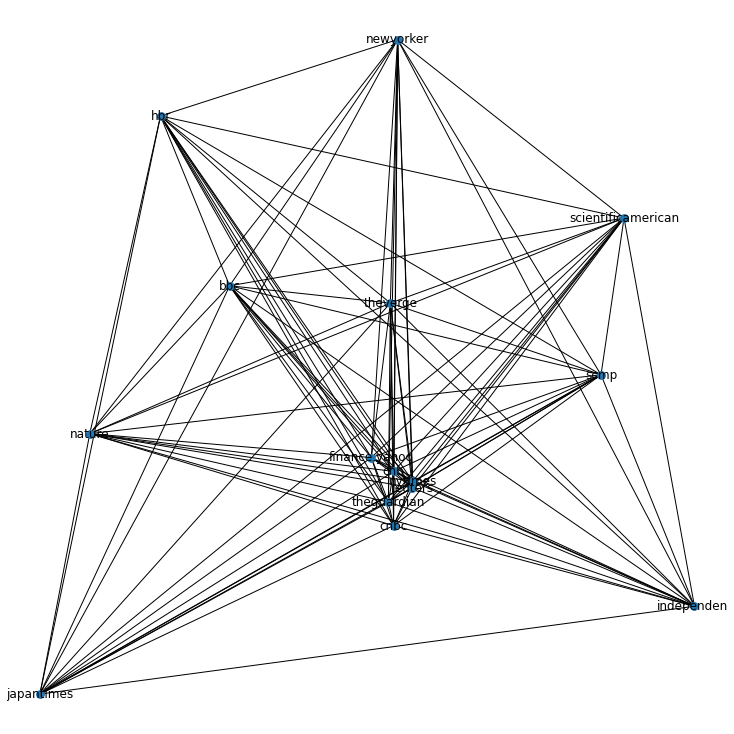

In [72]:
## Create a domain dict with the respective weights for the various topics
domains = df.domain.unique().tolist()
lda_topics = df['lda_topic'].unique().tolist()

weight_domain_dict = {}
for domain in domains:
    valueCounts = df[df["domain"] == domain].lda_topic.value_counts()
    active_topics = valueCounts.index.tolist()
    active_topic_values = valueCounts.tolist()
    if weight_domain_dict.get(domain, False) == False:
        weight_domain_dict[domain] = {}
    weight_domain_dict[domain]["total_articles"] = sum(active_topic_values)

    for i in range(len(active_topics)):
        weight_domain_dict[domain][active_topics[i]] = active_topic_values[i]

for domain in weight_domain_dict.keys():
    sub_dict = weight_domain_dict[domain]
    for topic, count in sub_dict.items():
        if topic != "total_articles":
            percentage = count / sub_dict["total_articles"]
            sub_dict[topic] = {
                "count": count,
                "percentage": percentage,
            }

# json.dump(weight_domain_dict, open("weight_domain_dict.json", "w+"), indent=2)   

G = nx.Graph()
## Example:
## G.add_edge("a", "b", weight=0.6)

## Filter weight_domain_dict
targetted_companies = ['cnn', 'theguardian', 'nature', 'scientificamerican', 'nytimes','cnbc', 'bbc','scmp', 'reuters', 'finance.yahoo','theverge','independent', 'newyorker','japantimes','hbr']
weight_domain_dict = {k: v for k,v in weight_domain_dict.items() if k in targetted_companies}

for i in range(len(weight_domain_dict.keys())):
    domains = list(weight_domain_dict.keys())
    target_domain_name = domains[i]
    other_domains = domains[:i] + domains[i + 1:]
    domain = weight_domain_dict[target_domain_name]

    for other_domain_name in other_domains:
        other_domain = weight_domain_dict[other_domain_name]
        other_domain_topics = list(other_domain.keys())

        for topic in list(domain.keys())[1:]:
            if other_domain.get(topic, False):
                if G.get_edge_data(target_domain_name, other_domain_name) == None:
                    G.add_edge(target_domain_name, other_domain_name, weight=0)
                old_weight = G.get_edge_data(target_domain_name, other_domain_name)["weight"]
                new_weight = old_weight + min(domain[topic]["count"], other_domain[topic]["count"])

                G.add_edge(target_domain_name, other_domain_name, weight=new_weight)



## Graphing code no need to edit below
plt.figure(figsize=(10,10))
# edge_list = [(u, v) for (u, v, d) in G.edges(data=True)]
# pos = nx.spring_layout(G, k=5, iterations=20)
# nx.draw_networkx_nodes(G, pos, node_size=60)
# nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=1)
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
nx.draw(G, with_labels=True, node_size=60)
plt.axis("off")
plt.show()